In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from imblearn.over_sampling import SMOTE
import os
os.environ['NUMEXPR_MAX_THREADS'] = '16'
from matplotlib import pyplot as plt
import pickle
from tensorflow.keras import regularizers

In [2]:
data = pd.read_csv("Dataset.csv")

In [3]:
data

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,21,21,83.0,99.0,NaN,121.0,77.0,54.0,22.0,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,22,0,113911
1552206,22,22,80.0,92.0,NaN,102.0,73.0,51.0,24.0,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,23,0,113911
1552207,23,23,95.0,97.0,36.7,128.5,83.0,58.5,25.0,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,24,0,113911
1552208,24,24,104.0,99.0,NaN,127.0,85.0,59.0,24.0,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,25,0,113911


In [4]:
patient_ids_sepsis = set(data[data["SepsisLabel"] == 1]["Patient_ID"])

sepsis_patients = data[(data["Patient_ID"].isin(patient_ids_sepsis)) & (data["SepsisLabel"] == 0)]

sepsis_dataset = pd.DataFrame()

for sepsis_patient in patient_ids_sepsis:
    patient_slice = sepsis_patients[sepsis_patients["Patient_ID"] == sepsis_patient]
    sepsis_dataset = pd.concat([sepsis_dataset, patient_slice], axis = 0)

In [5]:
len(sepsis_patients)

144494

In [6]:
half_size = len(patient_ids_sepsis) // 2
sampled_half = random.sample(list(patient_ids_sepsis), half_size)
other_half = patient_ids_sepsis.difference(set(sampled_half))

In [7]:
train_sepsis = sepsis_patients[sepsis_patients["Patient_ID"].isin(sampled_half)]

In [8]:
test_sepsis = sepsis_patients[sepsis_patients["Patient_ID"].isin(other_half)]

In [9]:
patient_ids_non_sepsis = set(data[data["SepsisLabel"] == 0]["Patient_ID"])

In [10]:
non_sepsis_patients = data[data["SepsisLabel"] == 0]

In [11]:
len(non_sepsis_patients)

1524294

In [12]:
random.seed(123)
half_size = len(patient_ids_non_sepsis) // 2
sampled_half = random.sample(list(patient_ids_non_sepsis), half_size)
other_half = patient_ids_non_sepsis.difference(set(sampled_half))

In [13]:
test_non_sepsis = non_sepsis_patients[non_sepsis_patients["Patient_ID"].isin(sampled_half)]

In [14]:
train_non_sepsis = non_sepsis_patients[non_sepsis_patients["Patient_ID"].isin(other_half)]

In [15]:
train_sepsis['SepsisLabel'] = train_sepsis['SepsisLabel'].replace(0, 1)

C:\Users\kevin\AppData\Local\Temp\ipykernel_20136\2790480915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sepsis['SepsisLabel'] = train_sepsis['SepsisLabel'].replace(0, 1)


In [16]:
test_sepsis['SepsisLabel'] = test_sepsis['SepsisLabel'].replace(0, 1)

C:\Users\kevin\AppData\Local\Temp\ipykernel_20136\271134428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sepsis['SepsisLabel'] = test_sepsis['SepsisLabel'].replace(0, 1)


# Outlier removal (hours)

In [17]:
train_sepsis["Hour"].describe()

count    67710.000000
mean        56.213750
std         53.751227
min          0.000000
25%         16.000000
50%         40.000000
75%         80.000000
max        329.000000
Name: Hour, dtype: float64

In [18]:
43 + 1.5 * (88 - 17)

149.5

In [19]:
train_sepsis = train_sepsis[train_sepsis["Hour"] < 150]

In [20]:
test_sepsis["Hour"].describe()

count    76784.000000
mean        62.532819
std         57.586078
min          0.000000
25%         18.000000
50%         45.000000
75%         91.000000
max        329.000000
Name: Hour, dtype: float64

In [21]:
42 + 1.5 * (84 - 17)

142.5

In [22]:
test_sepsis = test_sepsis[test_sepsis["Hour"] < 143]

In [23]:
train_non_sepsis["Hour"].describe()

count    764214.000000
mean         25.536150
std          29.603779
min           0.000000
25%           9.000000
50%          19.000000
75%          33.000000
max         335.000000
Name: Hour, dtype: float64

In [24]:
19 + 1.5 * (33 - 9)

55.0

In [25]:
train_non_sepsis = train_non_sepsis[train_non_sepsis["Hour"] < 55]

In [26]:
test_non_sepsis["Hour"].describe()

count    760080.000000
mean         24.400654
std          25.762528
min           0.000000
25%           9.000000
50%          19.000000
75%          33.000000
max         335.000000
Name: Hour, dtype: float64

In [27]:
19 + 1.5 * (33 - 9)

55.0

In [28]:
test_non_sepsis = test_non_sepsis[test_non_sepsis["Hour"] < 55]

In [29]:
train_sepsis.shape

(62785, 44)

In [30]:
train_non_sepsis.shape

(720312, 44)

In [31]:
len(train_non_sepsis) / len(train_sepsis)

11.472676594728041

# Majority class undersampling (non-sepsis)

In [32]:
train_non_sepsis = train_non_sepsis.sample(frac = 0.1)

In [33]:
test_sepsis.shape

(68415, 44)

In [34]:
test_non_sepsis.shape

(722331, 44)

In [35]:
len(train_non_sepsis) / len(train_sepsis)

1.1472644739985665

In [36]:
len(test_non_sepsis) / len(test_sepsis)

10.558079368559527

In [37]:
# test_non_sepsis = test_non_sepsis.sample(frac = 0.1)

In [38]:
X_train = pd.concat([train_sepsis, train_non_sepsis], axis = 0)
X_test = pd.concat([test_sepsis, test_non_sepsis], axis = 0)

In [39]:
y_train = X_train["SepsisLabel"]
y_test = X_test["SepsisLabel"]

In [40]:
X_train = X_train.drop(["Unnamed: 0", "SepsisLabel", "Patient_ID"], axis = 1)
X_test = X_test.drop(["Unnamed: 0", "SepsisLabel", "Patient_ID"], axis = 1)

# Median Value Imputation

In [41]:
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

# Scaling

In [42]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [43]:
sum(y_train) / len(y_train)

0.4657088179444576

In [44]:
sum(y_test) / len(y_test)

0.0865195650689349

In [62]:
model = Sequential()

model.add(Dense(512, input_dim=41))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(512, kernel_regularizer=regularizers.L1(0.01)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(512, kernel_regularizer=regularizers.L1(0.01)))
model.add(LeakyReLU(alpha=0.01))

model.add(Dense(1, activation='sigmoid'))

In [63]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

In [71]:
model.fit(X_train, y_train,
          epochs=100,
          batch_size=4,
          validation_split=0.2,
          callbacks=[early_stopping])

Epoch 1/100
26963/26963 [==============================] - 190s 7ms/step - loss: 1.1085 - accuracy: 0.6421 - val_loss: 1.2188 - val_accuracy: 0.9487
Epoch 2/100
26963/26963 [==============================] - 181s 7ms/step - loss: 1.1073 - accuracy: 0.6424 - val_loss: 1.1900 - val_accuracy: 0.9591
Epoch 3/100
 3281/26963 [==>...........................] - ETA: 2:35 - loss: 1.1048 - accuracy: 0.6441

KeyboardInterrupt: 

In [72]:
y_pred = np.round(model.predict(X_test))

24711/24711 [==============================] - 98s 4ms/step


In [73]:
sum(y_pred)

array([55954.], dtype=float32)

In [74]:
sum(y_test)

68415

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    722331
           1       0.52      0.43      0.47     68415

    accuracy                           0.92    790746
   macro avg       0.74      0.70      0.71    790746
weighted avg       0.91      0.92      0.91    790746



In [76]:
print(confusion_matrix(y_test, y_pred))

[[695740  26591]
 [ 39052  29363]]


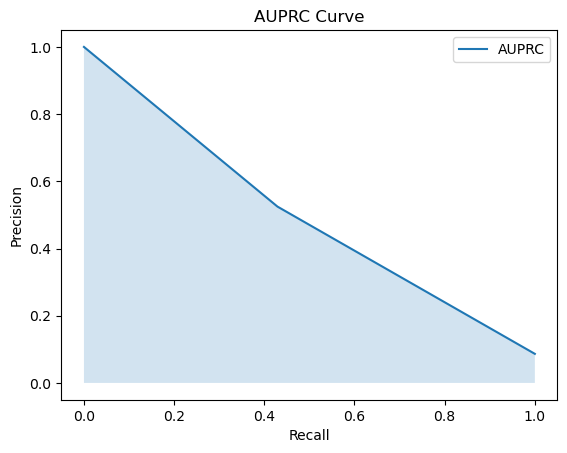

In [77]:
# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot auPRC curve
plt.plot(recall, precision, label='AUPRC')
plt.fill_between(recall, precision, alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve')
plt.legend()
plt.show()

get feature importances

In [78]:
model.save('DeepSepsis.h5')
# from keras.models import load_model
# model = load_model('my_model.h5')

C:\Users\kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 512)               21504     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                

In [80]:
len(X_train)

134816

In [81]:
sum(y_train) / len(y_train)

0.4657088179444576

In [82]:
len(X_test)

790746

In [83]:
sum(y_test) / len(y_test)

0.0865195650689349

In [84]:
weights = model.layers[0].get_weights()[0]

In [85]:
abs_weights = np.abs(weights)

In [86]:
feature_importance = np.sum(abs_weights, axis=1)

In [87]:
feature_importance = feature_importance / np.sum(feature_importance)

In [92]:
len(feature_importance)

41

In [88]:
print("Feature Importance:", feature_importance)

Feature Importance: [0.03303356 0.01667777 0.01688481 0.01752491 0.01830375 0.01910771
 0.01936323 0.01821769 0.01741438 0.03049004 0.01872205 0.03824347
 0.02058577 0.01769789 0.0178198  0.03487796 0.02202322 0.0173476
 0.01849112 0.01782265 0.03238716 0.03213912 0.01772762 0.02563673
 0.02421912 0.02082819 0.02056583 0.03775216 0.08107277 0.01826047
 0.01980177 0.01901487 0.0204238  0.01566436 0.01556291 0.01856412
 0.03749996 0.03184503 0.03272768 0.01500977 0.0326472 ]


In [100]:
len(feature_importance)

41

In [99]:
len(data.drop(["Unnamed: 0", "SepsisLabel", "Patient_ID", "SepsisLabel"], axis = 1).columns)

41

In [97]:
importances = dict(zip(data.drop(["Unnamed: 0", "SepsisLabel", "Patient_ID", "SepsisLabel"], axis = 1).columns.tolist(), feature_importance.tolist()))

In [101]:
importances

{'Hour': 0.03303355723619461,
 'HR': 0.016677772626280785,
 'O2Sat': 0.016884811222553253,
 'Temp': 0.01752491481602192,
 'SBP': 0.018303746357560158,
 'MAP': 0.01910771243274212,
 'DBP': 0.019363228231668472,
 'Resp': 0.01821768656373024,
 'EtCO2': 0.017414379864931107,
 'BaseExcess': 0.030490035191178322,
 'HCO3': 0.01872205175459385,
 'FiO2': 0.03824346885085106,
 'pH': 0.020585766062140465,
 'PaCO2': 0.01769789308309555,
 'SaO2': 0.01781979762017727,
 'AST': 0.034877959638834,
 'BUN': 0.022023215889930725,
 'Alkalinephos': 0.01734759844839573,
 'Calcium': 0.018491122871637344,
 'Chloride': 0.017822647467255592,
 'Creatinine': 0.032387156039476395,
 'Bilirubin_direct': 0.032139118760824203,
 'Glucose': 0.017727622762322426,
 'Lactate': 0.025636734440922737,
 'Magnesium': 0.024219123646616936,
 'Phosphate': 0.020828189328312874,
 'Potassium': 0.020565833896398544,
 'Bilirubin_total': 0.03775215521454811,
 'TroponinI': 0.08107277005910873,
 'Hct': 0.018260465934872627,
 'Hgb': 0.01980

In [102]:
sorted_items = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract the keys from the sorted items
keys = [key for key, value in sorted_items]

# Print the keys
print(keys)

['TroponinI', 'FiO2', 'Bilirubin_total', 'Gender', 'AST', 'Hour', 'Unit2', 'ICULOS', 'Creatinine', 'Bilirubin_direct']


Elevated troponin in sepsis

https://pubmed.ncbi.nlm.nih.gov/19585902/